In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import signal
from IPython import display

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from keras.models import load_model

In [2]:
cascade_path = 'haarcascades/haarcascade_frontalface_default.xml'

In [3]:
model_path = 'model/facenet_keras.h5'
model = load_model(model_path)

In [4]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [5]:
def calc_embs(imgs, margin, batch_size):
    aligned_images = prewhiten(imgs)
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [6]:
class FaceDemo(object):
    def __init__(self, cascade_path):
        self.vc = None
        self.cascade = cv2.CascadeClassifier(cascade_path)
        self.margin = 10
        self.batch_size = 1
        self.n_img_per_person = 10
        self.is_interrupted = False
        self.data = {}
        self.le = None
        self.clf = None
        self.person_list = {} # associate with database person_id -> database_id
        self.num_person = 0
        self.database = [] # it should be a list {id : its_embed_vector}
        
        
    def _signal_handler(self, signal, frame):
        self.is_interrupted = True
        
    def capture_images(self, name='Unknown'):
        vc = cv2.VideoCapture(0)
        self.vc = vc
        if vc.isOpened():
            is_capturing, _ = vc.read()
        else:
            is_capturing = False

        imgs = []
        # ============ update person list ================ #
        if name not in self.person_list :
            self.person_list[name] = self.id
            self.id = self.id + 1
        
        signal.signal(signal.SIGINT, self._signal_handler)
        self.is_interrupted = False
        
        # ==================== debug ===================== #
        is_capturing = True
        
        while is_capturing:
            is_capturing, frame = vc.read()
            
            # ==================== debug ===================== #
            is_capturing = False
            # for debug usage 
            if name == 'ivan' :
                frame = cv2.imread('../img/test.jpg')
            else :
                frame = cv2.imread('../img/test2.jpg')
                
                
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = self.cascade.detectMultiScale(frame,
                                         scaleFactor=1.1,
                                         minNeighbors=3,
                                         minSize=(100, 100))
            
            
            if len(faces) != 0:
                face = faces[0]
                (x, y, w, h) = face
                left = x - self.margin // 2
                right = x + w + self.margin // 2
                bottom = y - self.margin // 2
                top = y + h + self.margin // 2
                img = resize(frame[bottom:top, left:right, :],
                             (160, 160), mode='reflect')
                imgs.append(img)
                cv2.rectangle(frame,
                              (left-1, bottom-1),
                              (right+1, top+1),
                              (255, 0, 0), thickness=2)
                # ================= calculate embed and store it ! ============== #
                emb = model.predict(prewhiten(img))
                if len(self.database) - 1 < self.num_person :
                    self.database.append([emb])
                else :
                    self.database[self.person_list[name]].append(emb)
                    
            print(len(self.database[self.person_list[name]]))
            plt.imshow(frame)
            plt.title('{}/{}'.format(len(imgs), self.n_img_per_person))
            plt.xticks([])
            plt.yticks([])
            display.clear_output(wait=True)
            self.data[name] = np.array(imgs)
            if len(imgs) == self.n_img_per_person:
                vc.release()
                self.data[name] = np.array(imgs)
                break
            try:
                plt.pause(0.1)
            except Exception:
                pass
            if self.is_interrupted:
                vc.release()
                break
                
    def train(self):
        labels = []
        embs = []
        names = self.data.keys()
        for name, imgs in self.data.items():
            embs_ = calc_embs(imgs, self.margin, self.batch_size)    
            labels.extend([name] * len(embs_))
            embs.append(embs_)

        embs = np.concatenate(embs)
        
        
        # ================ calculate the average vector of each person =========== #
        for key in self.person_list :
            feature = self.database[self.person_list[key]]
            new_feature = np.mean(np.array(feature), axis=1)
            self.database[self.person_list[key]] = new_feature.to_list()
            
            
        """no fucking use this !!!
        le = LabelEncoder().fit(labels)
        y = le.transform(labels)
        clf = SVC(kernel='linear', probability=True).fit(embs, y)
        
        self.le = le
        self.clf = clf
        """
        
        
        
    def whoAreYou(img) :
        emb = model.predict(prewhiten(img))
        for uid, feature in enumerate(self.database) :
            # ===================== calculate who the fuck are you ? ============== #
            # shit code here
            
            
            
    def infer(self):
        vc = cv2.VideoCapture(0)
        self.vc = vc
        if vc.isOpened():
            is_capturing, _ = vc.read()
        else:
            is_capturing = False

        signal.signal(signal.SIGINT, self._signal_handler)
        self.is_interrupted = False
        is_capturing = True
        while is_capturing:
            is_capturing, frame = vc.read()
            is_capturing = False
            # for debug usage 
            frame = cv2.imread('../img/test2.jpg')
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = self.cascade.detectMultiScale(frame,
                                         scaleFactor=1.1,
                                         minNeighbors=3,
                                         minSize=(100, 100))
            pred = None
            if len(faces) != 0:
                for faceid, (x, y, w, h) in enumerate(faces) :
                    left = x - self.margin // 2
                    right = x + w + self.margin // 2
                    bottom = y - self.margin // 2
                    top = y + h + self.margin // 2
                    img = resize(frame[bottom:top, left:right, :],
                                 (160, 160), mode='reflect')
                    shouldUpdate, pred = whoAreYou(img)
                    cv2.rectangle(frame,
                                  (left-1, bottom-1),
                                  (right+1, top+1),
                                  (255, 0, 0), thickness=2)
                    cv2.putText(frame, str(pred), (left-1, bottom-1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            plt.imshow(frame)
            plt.title(pred)
            plt.xticks([])
            plt.yticks([])
            display.clear_output(wait=True)
            try:
                plt.pause(0.1)
            except Exception:
                pass
            if self.is_interrupted:
                vc.release()
                break

In [7]:
f = FaceDemo(cascade_path)

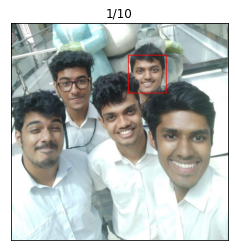

In [8]:
# Train with two or more people
f.capture_images('ivan')

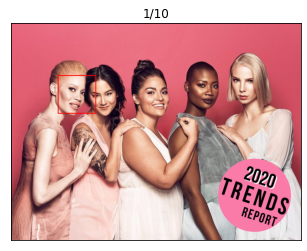

In [9]:
# Train with two or more people
f.capture_images('park seo joon')

In [10]:
f.train()

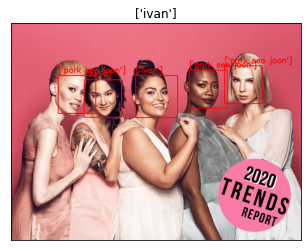

In [11]:
f.infer()

In [21]:
face_cascade = cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')

frame = cv2.imread('../img/test.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

faces = face_cascade.detectMultiScale(frame, 1.1, 4)

margin = 10
pred = None
if len(faces) != 0:
    for faceid, (x, y, w, h) in enumerate(faces) :
        left = x - margin // 2
        right = x + w + margin // 2
        bottom = y - margin // 2
        top = y + h + margin // 2
        img = resize(frame[bottom:top, left:right, :],
                     (160, 160), mode='reflect')
        embs = calc_embs(img[np.newaxis], margin, 1)
        pred = le.inverse_transform(clf.predict(embs))
        cv2.rectangle(frame,
                      (left-1, bottom-1),
                      (right+1, top+1),
                      (255, 0, 0), thickness=2)
        cv2.putText(img, str(pred), (left-1, bottom-1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, COLOR_BLUE, 2)
        cv2.imshow('img', img)

plt.imshow(frame)
plt.title(pred)
plt.xticks([])
plt.yticks([])
display.clear_output(wait=True)
try:
    plt.pause(0.1)
except Exception:
        pass


NameError: name 'self' is not defined